In [59]:

from amuse.lab import units, Particles, Particle, SeBa, nbody_system, ph4, constants, Kepler
from amuse.ext.orbital_elements import new_binary_from_orbital_elements, orbital_elements_from_binary, generate_binaries, rel_posvel_arrays_from_orbital_elements
# from amuse.community.kepler.interface import initialize_from_elements
from amuse.community.kepler.interface import KeplerInterface
import numpy
import matplotlib.pyplot as plt


# stellar.parameters.RGB_wind_scheme = 0
# stellar.parameters.AGB_wind_scheme = 0
# stellar.particles[i].mass_change = dmdt
# dmdt = -2.e-2 | units.MSun/units.yr

def orbital_period(a, Mtot):
    return 2*numpy.pi*(a**3/(constants.G*Mtot)).sqrt()

def semimajor_axis(P, Mtot):
    return (constants.G*Mtot*P**2/(4*numpy.pi**2))**(1./3)

def initialize_particles():
    particles = Particles(3)
    star_1 = particles[0]
    star_1.mass = 40.2|units.MSun
    star_1.radius = 45|units.RSun
    star_1.luminosity = 5.1e5 | units.LSun
    star_1.temperature = 2e4 | units.K
    star_1.mass_change = -1.1e-5 |units.MSun/units.yr
    star_1.wind_scheme = 2000 |units.km/units.s

    star_2 = particles[1]
    star_2.mass = 28.7|units.MSun
    star_2.radius = 13|units.RSun
    star_2.luminosity = 1.8e5| units.LSun
    star_2.temperature = 3.3e4| units.K
    star_2.mass_change = -4.2e-7 |units.MSun/units.yr
    star_2.wind_scheme = 1000 |units.km/units.s

    star_3 = particles[2]
    star_3.mass = 19.8|units.MSun
    star_3.radius = 7.9|units.RSun
    star_3.luminosity = 5.8e4| units.LSun
    star_3.temperature = 3.2e4| units.K
    star_3.mass_change = -4.9e-8 |units.MSun/units.yr
    star_3.wind_scheme = 1000 |units.km/units.s

    stellar = SeBa()
    stellar.particles.add_particle(star_1)
    stellar.particles.add_particle(star_2)
    stellar.particles.add_particle(star_3)

    stellar.parameters.metallicity = .2

    converter = nbody_system.nbody_to_si(1|units.AU, 1|units.MSun)

    period = 19|units.day
    semi_major = semimajor_axis(period, star_1.mass + star_2.mass)
    
    binary1_2 = new_binary_from_orbital_elements(star_1.mass , star_2.mass, semi_major, .2, G = constants.G)
#     binary1_3 = new_binary_from_orbital_elements(binary1_2.mass.sum(), star_3.mass, 100|units.au, .6, G = constants.G)
    
    
#     binary1_2 = Kepler(converter)
#     binary1_2.initialize_from_elements(mass = star_1.mass + star_2.mass, semi = semi_major, ecc = .2, mean_anomaly = 180)

#     binary1_3 = Kepler(converter)
    pos_vec, vel_vec = rel_posvel_arrays_from_orbital_elements(star_1.mass + star_2.mass, 
                                                               star_3.mass, 100|units.au, eccentricity = .6, 
                                                               inclination = 60,
                                                               argument_of_periapsis = 180,
                                                               G = constants.G)
    
#     pos_vec = binary1_3.get_separation_vector()
#     vel_vec = binary1_3.get_velocity_vector()
    
    star_1.position = binary1_2[0].position
    star_2.position = binary1_2[1].position
    
    star_1.velocity = binary1_2[0].velocity
    star_2.velocity = binary1_2[1].velocity
    
    particles.move_to_center()
    
    star_3.position = binary1_2.center_of_mass() + pos_vec[0]
    star_3.velocity = binary1_2.center_of_mass_velocity() + vel_vec[0]
    
    particles.move_to_center()
#     star_1.position = (0,0,0)|units.au
#     star_2.position = (binary1_2.get_separation_vector())
#     star_3.position = (binary1_3.get_separation_vector())

#     star_1.velocity = (0,0,0)|units.kms
#     star_2.velocity = binary1_2.get_velocity_vector()
#     star_3.velocity = binary1_3.get_velocity_vector()
    
    gravity = ph4(converter, number_of_workers = 32, mode = "GPU")
    gravity.particles.add_particles(particles)
    
    return (gravity, stellar, particles)

#Update to get inclination

In [19]:
def get_elements(stars):
    binary1_2 = Particles()
    binary1_2.add_particle(stars[0])
    binary1_2.add_particle(stars[1])
    
    binary1_3 = Particles(1)
    binary1_3[0].mass = binary1_2.mass.sum()
    binary1_3[0].position = binary1_2.center_of_mass()
    binary1_3[0].velocity = binary1_2.center_of_mass_velocity()
    binary1_3.add_particle(stars[2])
    
    M1, M2, ain, ein, ta_in, inc_in, lan_in, aop_in \
        = orbital_elements_from_binary(binary1_2, G=constants.G)
    M12, M3, aout, eout, ta_out, outc_out, lan_out, aop_out \
        = orbital_elements_from_binary(binary1_3, G=constants.G)
    return ain, ein, aout, eout

In [61]:
def evolve_stellar_gravity(max_delta_mass, tmax, dt):

    while stellar.model_time < tmax:

        inital_mass = particles.total_mass()
        stellar.evolve_model(stellar.model_time + dt)
        channel_from_stellar_to_gravity.copy()
        
        gravity.evolve_model(gravity.model_time + dt)
        channel_from_gravity_to_stellar.copy()
        channel_from_stellar_to_framework.copy()
        
#         channel_from_gravity_to_binary1_2.copy()
#         channel_from_gravity_to_binary1_3.copy()
        
#         delta_mass = inital_mass - particles.total_mass()

#         if delta_mass < max_delta_mass:
#             dt += .2|units.yr
#         elif (delta_mass > max_delta_mass):
#             dt -= .2|units.yr 
#         else:
#             print('good')
        
        semimajor12, ecc12, semimajor13, ecc13 = get_elements(particles)
        binary1_2_semimajor.append(semimajor12)
        binary1_2_eccentricity.append(ecc12)
#         temp_inclination = inclination
        
        
        binary1_3_semimajor.append(semimajor13)
        binary1_3_eccentricity.append(ecc13)
#         relative_inclination.append(abs(temp_inclination - inclination))
        
        time.append(gravity.model_time)
    


In [57]:
def plot_elements(dt):
    global binary1_2_semimajor, binary1_3_semimajor, binary1_2_eccentricity, binary1_3_eccentricity, semimajor
    plt.figure()
    binary1_2_semimajor /= binary1_2_semimajor[0].value_in(units.m)
    binary1_3_semimajor /= binary1_3_semimajor[0].value_in(units.m)
    
    binary1_2_eccentricity /= binary1_2_eccentricity[0]
    binary1_3_eccentricity /= binary1_3_eccentricity[0]
    
    plt.plot(time.value_in(units.yr), binary1_2_semimajor.value_in(units.m), 'r-', label = '12')
    plt.plot(time.value_in(units.yr), binary1_3_semimajor.value_in(units.m), 'b-', label = '13')
    plt.title('semi_major for dt: {}'.format(dt))
    plt.legend()
    
    plt.figure()
    plt.plot(time.value_in(units.yr), binary1_2_eccentricity, 'r-', label = '12')
    plt.plot(time.value_in(units.yr), binary1_3_eccentricity, 'b-', label = '13')
    plt.title('eccentricity for dt: {}'.format(dt))
    plt.legend()
#     plt.figure()
#     plt.plot(time.value_in(units.yr), relative_inclination)
#     plt.title('relative inclination for dt: {}'.format(dt))
    

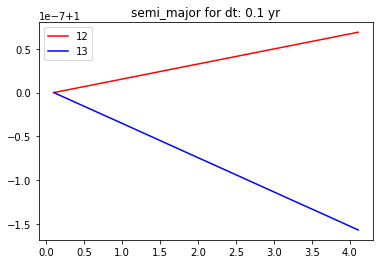

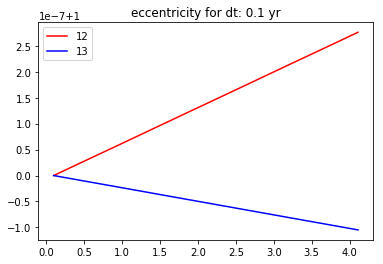

In [63]:
max_delta_mass = 1e-6|units.MSun
tmax = 4|units.yr
dt = .1|units.yr

time = []|units.yr

binary1_2_semimajor = []|units.m
binary1_3_semimajor = []|units.m

binary1_2_eccentricity = []
binary1_3_eccentricity = []

relative_inclination = []

gravity, stellar, particles = initialize_particles()

# binary1_2 = Particles()
# binary1_3 = Particles()

# binary1_2.add_particle(particles[0])
# binary1_2.add_particle(particles[1])

# binary1_3.add_particle(particles[0])
# binary1_3.add_particle(particles[2])

# kep_binary1_2 = Kepler(converter)
# kep_binary1_3 = Kepler(converter)

# kep_binary1_2.initialize_from_particles(temp_binary1_2)
# kep_binary1_3.initialize_from_particles(temp_binary1_3)

channel_from_gravity_to_framework = gravity.particles.new_channel_to(particles)
channel_from_gravity_to_stellar   = gravity.particles.new_channel_to(stellar.particles)
channel_from_stellar_to_framework = stellar.particles.new_channel_to(particles)
channel_from_stellar_to_gravity   = stellar.particles.new_channel_to(gravity.particles)
# channel_from_gravity_to_binary1_2 = gravity.particles.new_channel_to(binary1_2)
# channel_from_gravity_to_binary1_3 = gravity.particles.new_channel_to(binary1_3)

evolve_stellar_gravity(max_delta_mass, tmax, dt)
stellar.stop()
gravity.stop()
plot_elements(dt)


In [135]:
binary1_2_semimajor = []|units.m
binary1_2_semimajor.append(1|units.m)
binary1_2_semimajor.append(2|units.m)
binary1_2_semimajor.append(3|units.m)

binary1_2_semimajor /= binary1_2_semimajor[2].value_in(units.m)
print(binary1_2_semimajor)

[0.333333333333, 0.666666666667, 1.0] m


In [ ]:
# binary1_2[0].position


# binary1_2[1].position



# binary1_3 = new_binary_from_orbital_elements(star_1.mass + star_1.mass, star_3.mass, semi_major.value_in(units.au) + 100|units.au, eccentricity = .6,
#                                             true_anomaly= 180, argument_of_periapsis= 180, inclination = 60, G = constants.G)



# binary1_3[0].position

# binary1_3[1].position

In [ ]:
help(new_binary_from_orbital_elements)

In [ ]:
help(KeplerInterface)

In [ ]:
help(Kepler)

In [ ]:
help(orbital_elements_from_binary)

In [80]:
l = [1,2,3,4,5]
a, b = l[2], l[3]

In [175]:
a = numpy.array([(1,2,3),(4,5,6), (7,8,9)])
b = numpy.array([(1,2,3),(4,5,6), (7,8,9)])



In [52]:
particles = Particles(3)
star_1 = particles[0]
star_1.mass = 40|units.MSun
star_1.radius = 45|units.RSun
star_1.luminosity = 5.1e5 | units.LSun
star_1.temperature = 2e4 | units.K
star_1.mass_change = -1.1e-5 |units.MSun/units.yr
star_1.wind_scheme = 2000 |units.km/units.s

star_2 = particles[1]
star_2.mass = 29|units.MSun
star_2.radius = 13|units.RSun
star_2.luminosity = 1.8e5| units.LSun
star_2.temperature = 3.3e4| units.K
star_2.mass_change = -4.2e-7 |units.MSun/units.yr
star_2.wind_scheme = 1000 |units.km/units.s

star_3 = particles[2]
star_3.mass = 20|units.MSun
star_3.radius = 7.9|units.RSun
star_3.luminosity = 5.8e4| units.LSun
star_3.temperature = 3.2e4| units.K
star_3.mass_change = -4.9e-8 |units.MSun/units.yr
star_3.wind_scheme = 1000 |units.km/units.s

converter = nbody_system.nbody_to_si(1|units.AU, 1|units.MSun)

period = 19|units.day
semi_major = semimajor_axis(period, star_1.mass + star_2.mass)

binary12_test1 = new_binary_from_orbital_elements(star_1.mass , star_2.mass, semi_major, .2, G = constants.G)
binary12_kep = Kepler(converter)

binary12_kep.initialize_from_elements(mass = star_1.mass + star_2.mass, semi = semi_major, ecc = .2)


[]

In [53]:
M1, M2, ain, ein, ta_in, inc_in, lan_in, aop_in \
        = orbital_elements_from_binary(binary12_test1, G=constants.G)
acc, ecc = binary12_kep.get_elements()

# print(binary12_test1[1].position - binary12_test1[0].position)
#print(binary12_kep.get_separation_vector())
# print(0.00278328051813*24578097721331.34)
#print(binary12_test1[0].position)
print(semi_major)

0.00347910064767 (1.48472082432e+40 * m**3)**0.3333333333333333


In [ ]:
# a = generate_binaries(star_1.mass, star_2.mass, semi_major, eccentricity = .2, argument_of_periapsis= 180, G = constants.G)
# # b = generate_binaries(star_1.mass + star_2.mass, )

In [ ]:
#Code Graveyard:
#binary1_2 = new_binary_from_orbital_elements(star_1.mass, star_2.mass, semi_major, eccentricity = .2, 
#                                            true_anomaly =  180, argument_of_periapsis = 180, G = constants.G)

#binar1_2_kep = Kepler((star_1.mass + star_2.mass).value_in(units.kg), semi = semi_major.value_in(units.km), ecc = .2) #mean_anomaly = 180|units.deg, periastron
